#### Import Libraries

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import seaborn as sns

#### Connect To Database

In [2]:
try:
    cnx = mysql.connector.connect(user='root', password='Superboy2008@#$',
                              host='localhost',
                              database='chelseachannel')
except mysql.connector.Error as err:
    print(err)

#### Querying Data From Database

In [3]:
cursor = cnx.cursor()
query = ("SELECT * from videos WHERE recordTime = CURDATE()")
cursor.execute(query)

videos = []
for item in cursor:
    videos.append(item)

cursor.close()

True

#### Put Videos in to DataFrame

In [4]:
videos_df = pd.DataFrame(videos, 
                         columns=['videoid', 'recordTime', 'title', 'publishedAt', 'duration', 
                                  'viewCount', 'likeCount', 'favoriteCount', 'commentCount'])

videos_df['recordTime'] = pd.to_datetime(videos_df['recordTime'])
videos_df['publishedAt'] = pd.to_datetime(videos_df['publishedAt'])

videos_df.to_excel('videos.xlsx')

videos_df.head()

,videoid,recordTime,title,publishedAt,duration,viewCount,likeCount,favoriteCount,commentCount
0,-26dydSuThg,2023-07-12,leeds 0 0 chelsea premier league highlights,2021-03-13,145,430368,7240,0,492
1,-5Bm8i2FE78,2023-07-12,mason mount & joe cole teamed up with sure to ...,2021-10-08,267,107590,5557,0,86
2,-6zaHxAp-Sw,2023-07-12,chelsea 2 0 wolves mason mount & olivier girou...,2020-07-26,124,1696979,30167,0,1437
3,-7NDgKCeUrc,2023-07-12,"""super happy to be going back to wembley "" mid...",2022-03-19,286,143269,4844,0,311
4,-eKiVyizfWM,2023-07-12,the very best team goals chelsea tops,2020-06-07,632,366303,7735,0,315


#### Start to Perform EDA

In [5]:
videos_df.describe()

,duration,viewCount,likeCount,favoriteCount,commentCount
count,513.000000,5.130000e+02,513.000000,513.0,513.000000
mean,866.029240,7.671643e+05,13382.760234,0.0,588.270955
std,1797.688201,1.031215e+06,14396.293269,0.0,666.894255
min,10.000000,1.681600e+04,742.000000,0.0,10.000000
25%,141.000000,1.730890e+05,4600.000000,0.0,183.000000
50%,298.000000,3.197900e+05,8307.000000,0.0,343.000000
75%,506.000000,9.023030e+05,15691.000000,0.0,745.000000
max,9805.000000,9.166661e+06,125045.000000,0.0,5027.000000


We can drop favoriteCount column, since it is all zeros.

In [6]:
videos_df = videos_df.drop(columns=['favoriteCount'])
videos_df.head()

,videoid,recordTime,title,publishedAt,duration,viewCount,likeCount,commentCount
0,-26dydSuThg,2023-07-12,leeds 0 0 chelsea premier league highlights,2021-03-13,145,430368,7240,492
1,-5Bm8i2FE78,2023-07-12,mason mount & joe cole teamed up with sure to ...,2021-10-08,267,107590,5557,86
2,-6zaHxAp-Sw,2023-07-12,chelsea 2 0 wolves mason mount & olivier girou...,2020-07-26,124,1696979,30167,1437
3,-7NDgKCeUrc,2023-07-12,"""super happy to be going back to wembley "" mid...",2022-03-19,286,143269,4844,311
4,-eKiVyizfWM,2023-07-12,the very best team goals chelsea tops,2020-06-07,632,366303,7735,315


#### Plot the Distribution For Each Quantitive Column

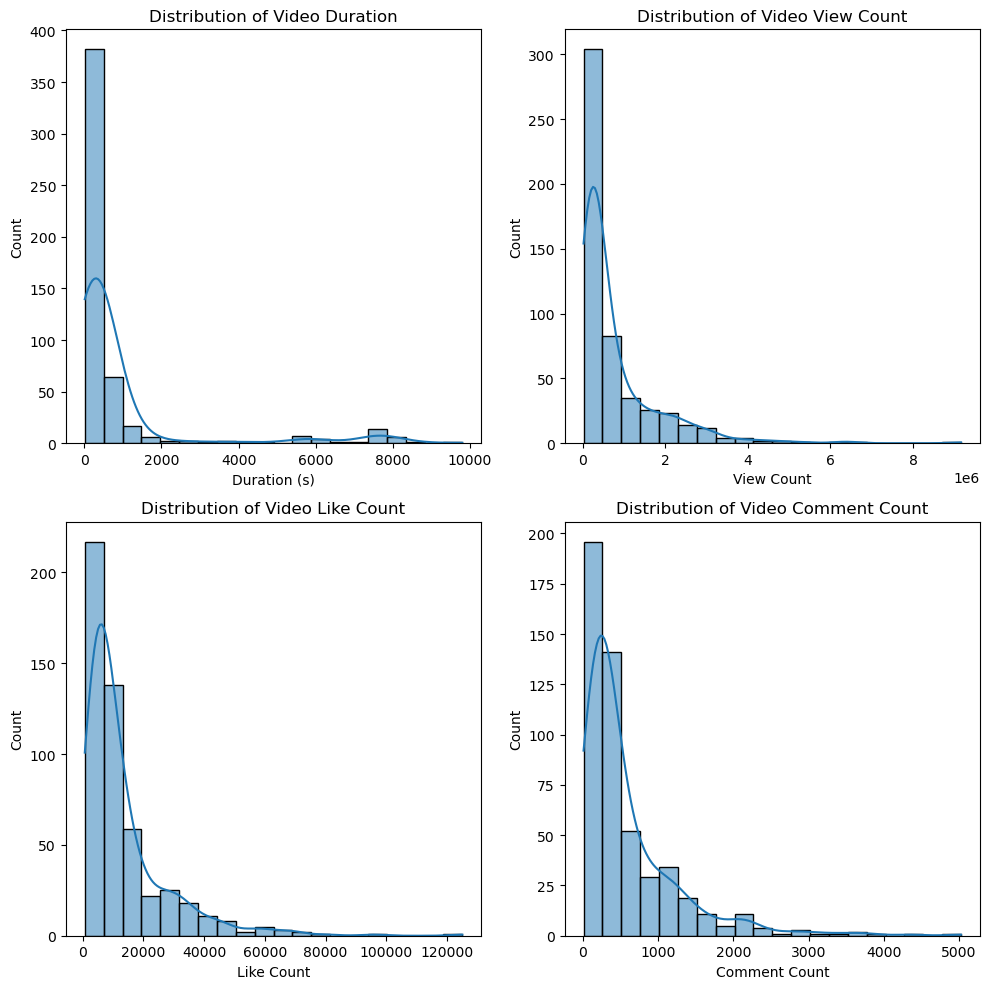

In [7]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)

plt.subplot(221)
sns.histplot(videos_df['duration'], kde=True, bins=20)
plt.title('Distribution of Video Duration')
plt.xlabel('Duration (s)')

plt.subplot(222)
sns.histplot(videos_df['viewCount'], kde=True, bins=20)
plt.title('Distribution of Video View Count')
plt.xlabel('View Count')

plt.subplot(223)
sns.histplot(videos_df['likeCount'], kde=True, bins=20)
plt.title('Distribution of Video Like Count')
plt.xlabel('Like Count')

plt.subplot(224)
sns.histplot(videos_df['commentCount'], kde=True, bins=20)
plt.title('Distribution of Video Comment Count')
plt.xlabel('Comment Count')

plt.show()

#### Correlation Matrix

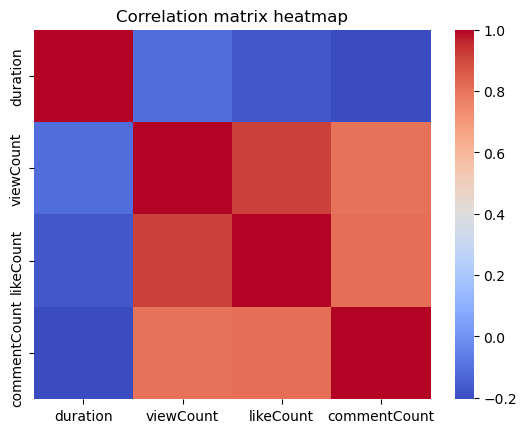

In [8]:
corr = videos_df.iloc[:,4:].corr()
plt.title('Correlation matrix heatmap')
sns.heatmap(corr, cmap='coolwarm')
plt.show()

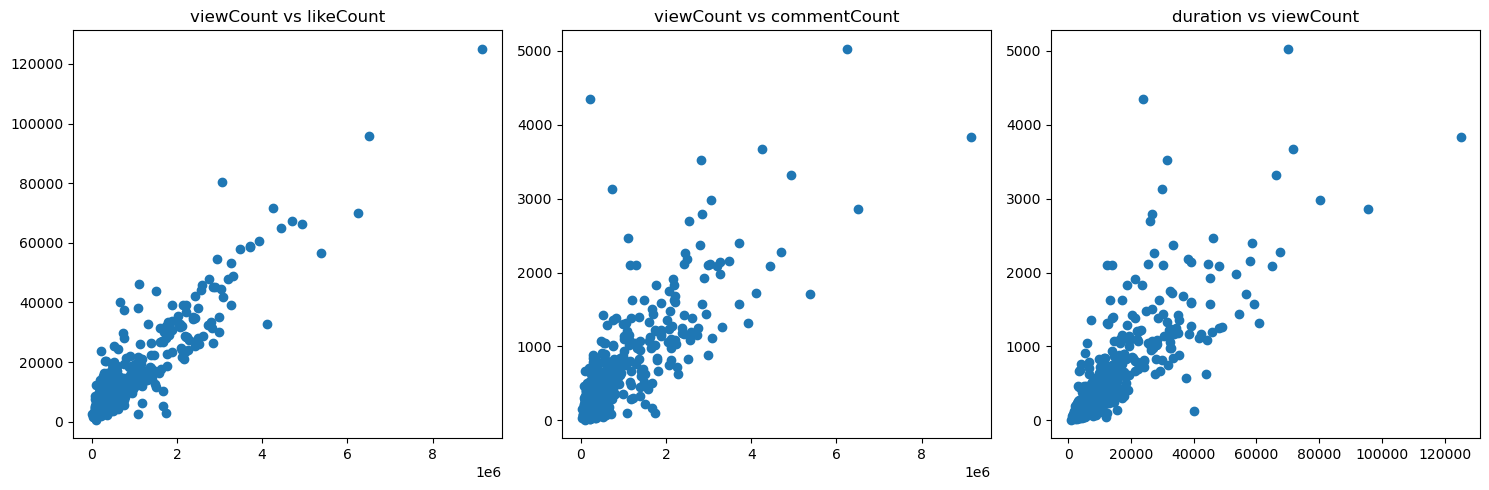

In [9]:
fig = plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(131)
plt.title('viewCount vs likeCount')
plt.scatter(videos_df['viewCount'], videos_df['likeCount'])

plt.subplot(132)
plt.title('viewCount vs commentCount')
plt.scatter(videos_df['viewCount'], videos_df['commentCount'])

plt.subplot(133)
plt.title('duration vs viewCount')
plt.scatter(videos_df['likeCount'], videos_df['commentCount'])

plt.show()

The number of views, likes, and comments of the video has high correlation. The more number of views a video has, the more likely it will be liked or commented. Besides that, duration has low correlation with number of views, likes and comments.

#### Number of Videos Published Overtime

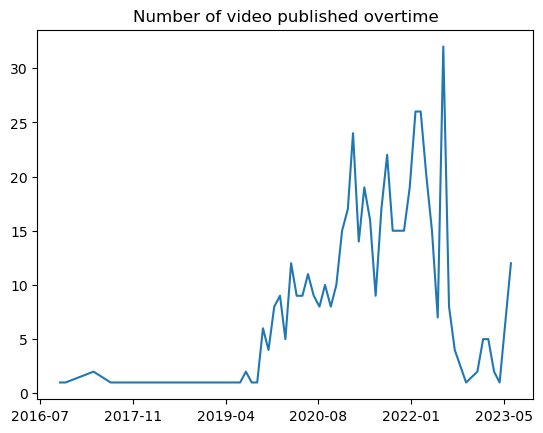

In [10]:
videos_publish_groupby = videos_df.groupby([videos_df['publishedAt'].dt.year, videos_df['publishedAt'].dt.month]).nunique()
videos_publish_by_month = videos_publish_groupby['videoid']

year_month_df = pd.DataFrame(np.array([videos_df['publishedAt'].dt.year, videos_df['publishedAt'].dt.month,  [1]*len(videos_df)]).T,
                            columns=['Year', 'Month', 'Day'])
year_month_df = pd.to_datetime(year_month_df)
dates = sorted(set(year_month_df))
x = date2num(dates)

plt.title('Number of video published overtime')
plt.plot(x, videos_publish_by_month, linestyle='solid')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.show()

The Channel Published more videos during regular season (August to May next year) than off-season (June to August).

#### Perform Clustering to Videos

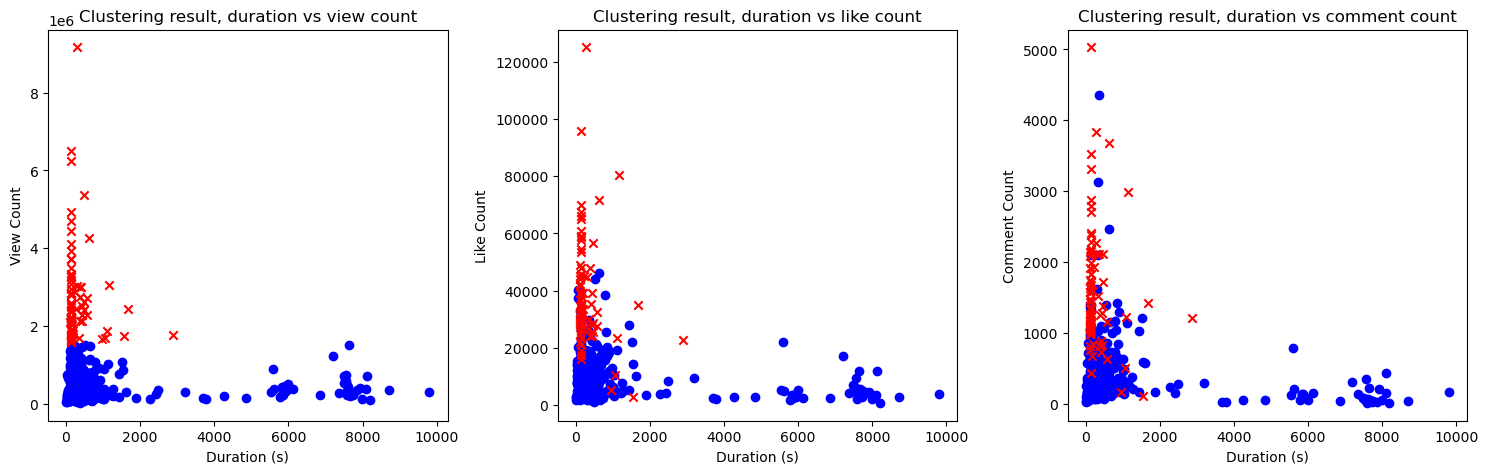

In [11]:
from sklearn.cluster import KMeans

video_np = videos_df.iloc[:,4:].to_numpy()
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(video_np)

res = kmeans.labels_

fig = plt.figure(figsize=(15, 5), tight_layout=True)

plt.subplot(131)
plt.title('Clustering result, duration vs view count')
plt.xlabel('Duration (s)')
plt.ylabel('View Count')
plt.scatter(video_np[:, 0][res == 1], video_np[:, 1][res == 1], c='b', marker='o')
plt.scatter(video_np[:, 0][res == 0], video_np[:, 1][res == 0], c='r', marker='x')

plt.subplot(132)
plt.title('Clustering result, duration vs like count')
plt.xlabel('Duration (s)')
plt.ylabel('Like Count')
plt.scatter(video_np[:, 0][res == 1], video_np[:, 2][res == 1], c='b', marker='o')
plt.scatter(video_np[:, 0][res == 0], video_np[:, 2][res == 0], c='r', marker='x')

plt.subplot(133)
plt.title('Clustering result, duration vs comment count')
plt.xlabel('Duration (s)')
plt.ylabel('Comment Count')
plt.scatter(video_np[:, 0][res == 1], video_np[:, 3][res == 1], c='b', marker='o')
plt.scatter(video_np[:, 0][res == 0], video_np[:, 3][res == 0], c='r', marker='x')
plt.show()

We can see that the K-means cluster divided the data in the leftest diagram into roughly two parts. Part 1: video with more view count while less duration. Part 2: video with less view count while more duration time. The data other two diagrams has more overlapping.